In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import torch
from tqdm.auto import tqdm

import maze
import env_utils
from functools import partial
import goexplore_discrete
from torch import nn
from mzr_old import layer_init

In [70]:
import maze_run

In [20]:
ges = torch.load('data/ges.pt')

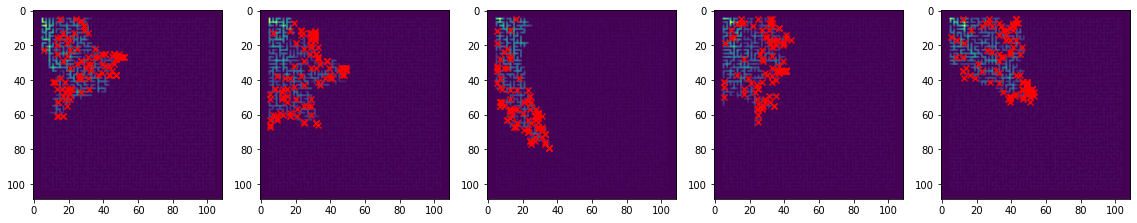

In [133]:
plt.figure(figsize=(40, 5))
for i_plt, ge in enumerate(ges[:5]):
    grid = ge.env.envs[0].maze.copy()
    cells = list(ge.cell2n_seen.keys())
    n_seen = list(ge.cell2n_seen.values())
    for i in range(len(cells)):
        y, x = cells[i]
        grid[y, x] = n_seen[i]
    plt.subplot(1, 10, i_plt+1)
    plt.imshow(grid)
    nodes = ge.select_nodes(100, beta=-2.0)
    # nodes = ge.select_nodes(100, beta=-0.5)
    cells = np.array([node.cell for node in nodes])
    plt.scatter(cells[:, 1], cells[:, 0], marker='x', c='r')

In [59]:
def create_bc_dataset(ges, n_nodes=10, beta=-0.5):
    x, y = [], []
    for ge in tqdm(ges):
        env = ge.env.envs[0]
        nodes = ge.select_nodes(n_nodes, beta=beta)
        for node in nodes:
            obs, info = env.reset()
            for action in node.snapshot:
                x.append(obs)
                y.append(action)
                obs, reward, terminated, truncated, info = env.step(action)
    x, y = np.stack(x), np.asarray(y)
    x, y = torch.as_tensor(x).float(), torch.as_tensor(y).long()
    return x, y
x_train, y_train = create_bc_dataset(ges, 10)
print(x_train.shape, y_train.shape)

100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


torch.Size([212212, 4, 11, 11]) torch.Size([212212])


In [73]:
class RandomExplorer(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.n_actions = envs.single_action_space.n
    def forward(self, x):
        return self.get_dist_and_values(x)
    def get_dist_and_values(self, x):
        logits = torch.zeros(x.shape[0], self.n_actions, device=x.device)
        values = torch.zeros(x.shape[0], 1, device=x.device)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, values[:, 0]
    def act(self, x):
        dist, _ = self.get_dist_and_values(x)
        return dist.sample()

class ImitationExplorer(nn.Module):
    def __init__(self, envs, num_frames=4):
        super().__init__()
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(num_frames, 16, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(16, 32, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 3 * 3, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)
    def forward(self, x):
        return self.get_dist_and_values(x)

    def get_dist_and_values(self, x):
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, values[:, 0]

    def act(self, x):
        dist, _ = self.get_dist_and_values(x)
        return dist.sample()

In [97]:
def train_bc_agent(agent, x_train, y_train, batch_size=32, n_batches=10, lr=1e-3, coef_entropy=0.0, device=None, tqdm=None):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    opt = torch.optim.Adam(agent.parameters(), lr=lr)
    pbar = range(n_batches)
    if tqdm is not None:
        pbar = tqdm(pbar)
    for i_batch in pbar:
        idxs_batch = torch.randperm(len(x_train))[:batch_size]
        x_batch, y_batch = x_train[idxs_batch].float().to(device), y_train[idxs_batch].long().to(device)
        dist, values = agent.get_dist_and_values(x_batch)

        loss_bc = loss_fn(dist.logits, y_batch).mean()
        loss_entropy = dist.entropy().mean()
        loss = loss_bc - coef_entropy * loss_entropy
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.set_postfix(loss_bc=loss_bc.item(), entropy=loss_entropy.item())


In [98]:
agent = ImitationExplorer(ge.env)
train_bc_agent(agent, x_train, y_train, batch_size=512, n_batches=10000, tqdm=tqdm)

 31%|███       | 3091/10000 [02:24<05:22, 21.42it/s, entropy=0.289, loss_bc=0.259]


KeyboardInterrupt: 

In [99]:
mazes_test = torch.load('data/mazes_test.pt')

In [102]:
def temp(agent=None):
    cells = [[] for maze in mazes_test]
    for i_maze, maze in enumerate(tqdm(mazes_test)):
        env = maze_run.make_env(1, maze=maze, obs_size=5, frame_stack=4)
        obs, info = env.reset()
        for i_trans in range(1000):
            cells[i_maze].append(info['cell'][0])
            obs, reward, terminated, truncated, info = env.step(agent.act(obs))
    a = np.array([len(set(i)) for i in cells])
    print(a.mean(), a.std())

temp(RandomExplorer(ge.env)) 
temp(agent) 

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


38.65 14.619422013198744


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]

78.54 41.514436043381345


In [137]:
np.random.seed(10032)
grid = maze.generate_maze(71, 71)
env_eval = maze_run.make_env(grid[None], 1, 4)

In [168]:
video = []
obs, info = env_eval.reset()
for i in tqdm(range(100)):
    video.append(obs[-1])
    obs, reward, terminated, truncated, info = env_eval.step(agent.act(obs))
video = np.concatenate(video, axis=0)

100%|██████████| 100/100 [00:00<00:00, 897.57it/s]


0


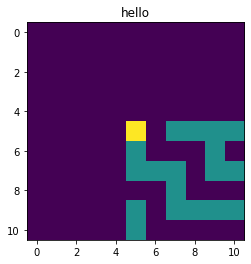

40


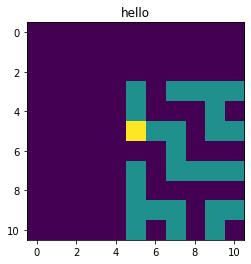

80


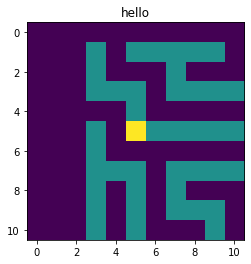

120


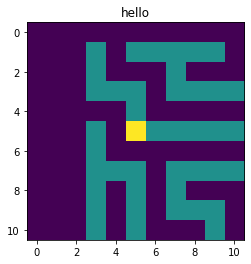

160


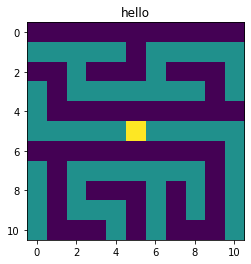

200


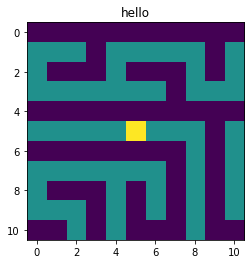

240


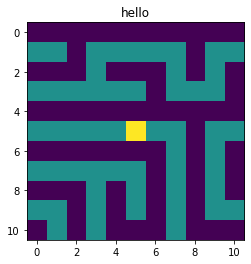

280


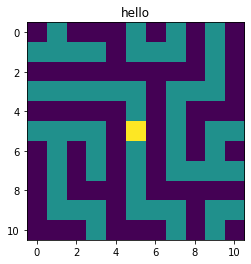

320


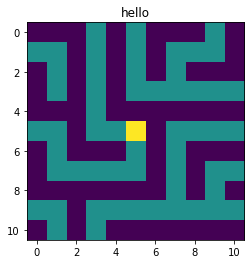

360


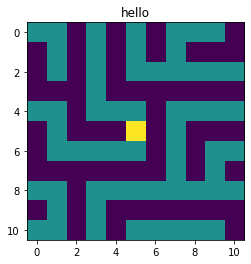

In [171]:
for i in range(0, len(video), 40):
    print(i)
    plt.imshow(video[i])
    plt.show()